In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from data_cleaning import demographic

In [16]:
data07 = pd.read_csv('~/Documents/dsi/capstone/capstone1/data/2007/2007_slim_data.csv')
data12 = pd.read_csv('~/Documents/dsi/capstone/capstone1/data/2012/2012_data.csv')
data17 = pd.read_csv('~/Documents/dsi/capstone/capstone1/data/2017/2017_data.csv')

def clean(data, year):
    if year == 2007:
        data07 = data
        data07['year'] = 2007
        data07['year'] = pd.to_numeric(data07['year'])
        data07['race1'] = data07['race'].str.slice(stop=1)
        data07['race2'] = data07['race'].str.slice(start=1).str.strip()
        pst_data07 = data07[data07['sector'] == 54]
        pst_df07 = pst_data07.groupby(['race1', 'race2','ethnicity','sex']).agg({'sector':'count'})
        percent07 = pst_df07.groupby(level=0).apply(lambda x: 100 * x / float(sum(pst_df07['sector'])))
        percent07.rename(columns={'sector':'percent'},inplace=True)
        out = percent07
    elif year == 2012:
        df12 = data.groupby(['RACE_GROUP_TTL', 'ETH_GROUP_TTL','SEX_TTL']).agg({'FIRMALL':'sum'})
        df12.rename(columns={'FIRMALL':'count'},inplace=True)
        df12.drop(index='Meaning of Race code',inplace=True)
        df12['count'] = pd.to_numeric(df12['count'])
        df12['percent'] = 100 * (df12['count'] / df12.iloc[0,0])
        percent12 = df12.sort_values('percent',ascending=False)
        out = percent12
    elif year == 2017:
        data17 = data[1:]
        data17['OWNPDEMP'].replace({'D':'1'}, inplace=True)
        data17['OWNPDEMP'] = pd.to_numeric(data17['OWNPDEMP'])
        data17 = data17[data17['OWNCHAR_LABEL'] == 'Total reporting']
        data17 = data17[data17['OWNER_RACE_LABEL'] != 'Minority']
        data17 = data17[data17['OWNER_RACE_LABEL'] != 'Nonminority']
        data17 = data17[data17['OWNER_VET_LABEL'] == 'All owners of respondent firms']
        df17 = data17.groupby(['OWNER_RACE_LABEL', 'OWNER_ETH_LABEL','OWNER_SEX_LABEL']).agg({'OWNPDEMP':'sum'})
        df17.rename(columns={'OWNPDEMP':'count'},inplace=True)
        df17['percent'] = 100 * (df17['count'] / df17.iloc[0,0])
        percent17 = df17.sort_values('percent',ascending=False)
        out = percent17
    return out

 
def demographic(demo, year):
    if year == 2007:
        data = data07
        if demo == 'race':
            race07 = clean(data, year).groupby(level=0).agg({'percent':'sum'})
            race07.sort_values('percent',ascending=False,inplace=True)
            race07.reset_index(inplace=True)
            race07.rename(columns={'race1':'race'},inplace=True)
            race07['race'] = np.array(['White','Asian','Black or African American','American Indian and Alaska Native', 'Some other race', 'Native Hawaiian and Other Pacific Islander'])
            out = race07
        elif demo == 'ethnicity':
            eth07 = clean(data, year).groupby(level=2).agg({'percent':'sum'})
            eth07.sort_values('percent',ascending=False,inplace=True)
            eth07.reset_index(inplace=True)
            eth07['ethnicity'] = np.array(['Non-Hispanic','Hispanic'])
            out = eth07
        elif demo == 'sex':
            sex07 = clean(data, year).groupby(level=3).agg({'percent':'sum'})
            sex07.sort_values('percent',ascending=False,inplace=True)
            sex07.reset_index(inplace=True)
            sex07['sex'] = np.array(['Male','Female'])
            out = sex07
        else:
            out = 'Invalid demographic input.  Valid inputs: \'race\', \'ethnicity\', or \'sex\''
        return out
    elif year == 2012:
        data = data12
        if demo == 'race':
            consolidate12 = clean(data, year)[1:].drop(index='All firms',level=0)
            consolidate12 = consolidate12[1:].drop(index='All firms',level=1)
            race12 = consolidate12.groupby(level=0).agg({'percent':'sum'})
            race12.sort_values('percent',ascending=False,inplace=True)
            race12.reset_index(inplace=True)
            race12.rename(columns={'RACE_GROUP_TTL':'race'},inplace=True)
            out = race12
        elif demo == 'ethnicity':
            eth12 = clean(data, year)[1:].drop(index='All firms',level=1)
            eth12.reset_index(inplace=True)
            eth12 = eth12[eth12['RACE_GROUP_TTL'] == 'All firms']
            eth12 = eth12[eth12['SEX_TTL'] == 'All firms']
            eth12 = eth12[eth12['ETH_GROUP_TTL'].isin(['Non-Hispanic', 'Hispanic'])]
            eth12 = eth12.drop(columns=['RACE_GROUP_TTL','SEX_TTL','count']).rename(columns={'ETH_GROUP_TTL':'ethnicity'})
            out = eth12
        elif demo == 'sex':
            sex12 = clean(data, year)[1:].drop(index='All firms',level=2)
            sex12 = sex12.loc[('All firms','All firms')]
            sex12 = sex12[1:].drop(columns='count')
            sex12.reset_index(inplace=True)
            sex12.rename(columns={'SEX_TTL':'sex'},inplace=True)
            sex12 = sex12[:2]
            sex12['sex'] = np.array(['Male','Female'])
            out = sex12
        else:
            out = 'Invalid demographic input.  Valid inputs: \'race\', \'ethnicity\', or \'sex\''
        return out
    elif year == 2017:
        data = data17
        if demo == 'race':
            consolidate17 = clean(data, year)[1:].drop(index='All owners of respondent firms',level=0)
            race17 = consolidate17.drop(index='Male',level=2)
            race17 = race17.drop(index='Female',level=2)
            race17 = race17.reset_index()
            race17 = race17.drop(columns=['OWNER_ETH_LABEL','OWNER_SEX_LABEL', 'count']).rename(columns={'OWNER_RACE_LABEL':'race'})
            out = race17
        elif demo == 'ethnicity':
            eth17 = clean(data, year)[1:].drop(index='All owners of respondent firms',level=1)
            eth17.reset_index(inplace=True)
            eth17 = eth17.drop(columns=['count','OWNER_RACE_LABEL']).rename(columns={'OWNER_ETH_LABEL':'ethnicity'})
            eth17 = eth17[eth17['OWNER_SEX_LABEL'] == 'All owners of respondent firms']
            eth17 = eth17.drop(columns='OWNER_SEX_LABEL')
            out = eth17
        elif demo == 'sex':
            sex17 = clean(data, year)[1:].drop(index='All owners of respondent firms',level=2)
            sex17 = sex17.loc[('All owners of respondent firms','All owners of respondent firms')]
            sex17.reset_index(inplace=True)
            sex17 = sex17.drop(columns='count').rename(columns={'OWNER_SEX_LABEL':'sex'})
            out = sex17
        else:
            out = 'Invalid demographic input.  Valid inputs: \'race\', \'ethnicity\', or \'sex\''
        return out
    else:
        out = 'Invalid year input.  Valid inputs: 2007, 2012, or 2017'
    return out

In [18]:
dlist = ['race', 'ethnicity', 'sex']
ylist = [2007, 2012, 2017]

for demo in dlist:
    for year in ylist:
        print(demographic(demo, year))

                                         race    percent
0                                       White  87.810378
1                                       Asian   6.650118
2                   Black or African American   4.613032
3           American Indian and Alaska Native   0.656534
4                             Some other race   0.154638
5  Native Hawaiian and Other Pacific Islander   0.115300
                                         race    percent
0                                       White  85.284708
1                                       Asian   7.104229
2                   Black or African American   5.308209
3                             Some other race   1.735664
4           American Indian and Alaska Native   0.794329
5  Native Hawaiian and Other Pacific Islander   0.161395
                                         race    percent
0                                       White  90.686082
1                                       Asian   7.859092
2                   Black or Af

In [19]:
r07 = demographic('race', 2007)
r12 = demographic('race', 2012)
r17 = demographic('race', 2017)
e07 = demographic('ethnicity', 2007)
e12 = demographic('ethnicity', 2012)
e17 = demographic('ethnicity', 2017)
s07 = demographic('sex', 2007)
s12 = demographic('sex', 2012)
s17 = demographic('sex', 2017)

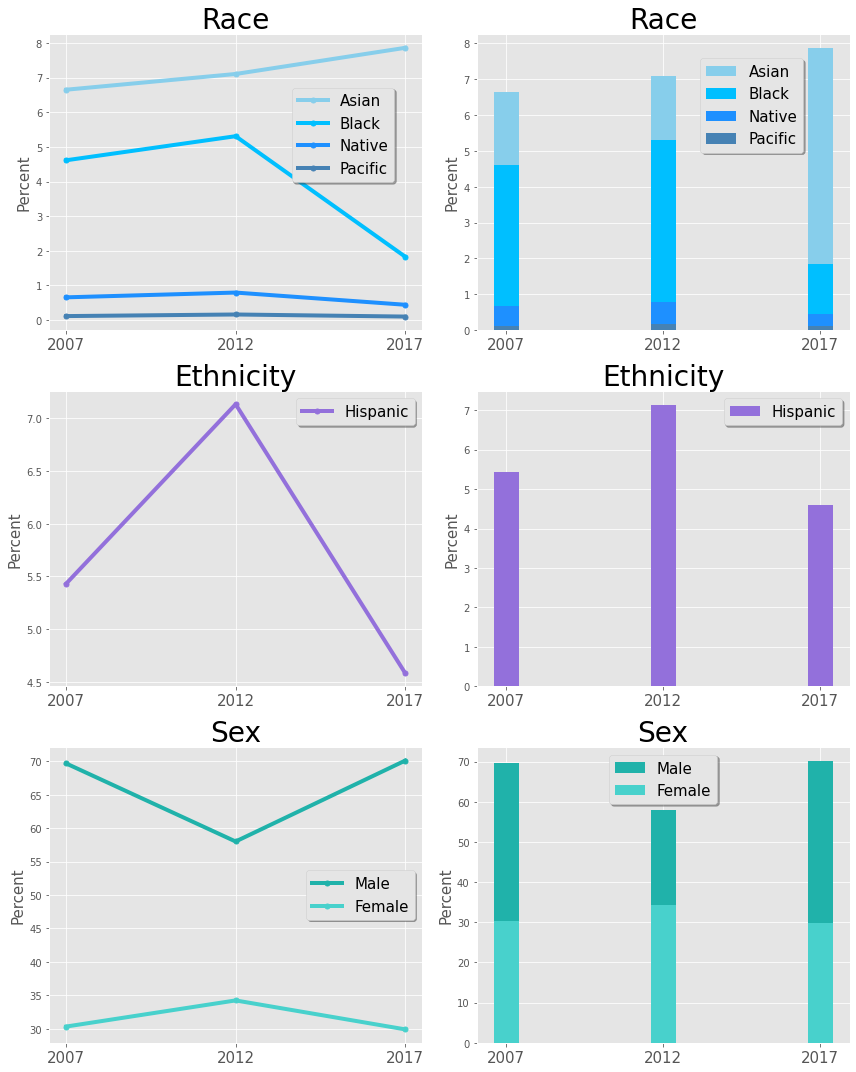

In [134]:
white_lst = [r07.at[0,'percent'],r12.at[0,'percent'],r17.at[0,'percent']]
asian_lst = [r07.at[1,'percent'],r12.at[1,'percent'],r17.at[1,'percent']]
black_lst = [r07.at[2,'percent'],r12.at[2,'percent'],r17.at[2,'percent']]
native_lst = [r07.at[3,'percent'],r12.at[4,'percent'],r17.at[3,'percent']]
pacific_lst = [r07.at[5,'percent'],r12.at[5,'percent'],r17.at[4,'percent']]
hispanic_lst = [e07.at[1,'percent'],e12.at[5,'percent'],e17.at[3,'percent']]
male_lst = [s07.at[0,'percent'],s12.at[0,'percent'],s17.at[0,'percent']]
female_lst = [s07.at[1,'percent'],s12.at[1,'percent'],s17.at[1,'percent']]



fig, ax = plt.subplots(3,2,figsize=(12,15))

ax[0][0].set_xticks(ylist)
ax[0][0].set_xticklabels(ylist, fontsize=15)
ax[0][0].set_title('Race', fontsize=28)
ax[0][0].set_ylabel('Percent',fontsize=15)
ax[0][0].plot(ylist, asian_lst, color="skyblue", linewidth=4.00, label='Asian', marker='o', markersize=5)
ax[0][0].plot(ylist, black_lst, color="deepskyblue", linewidth=4.00, label='Black', marker='o', markersize=5)
ax[0][0].plot(ylist, native_lst, color="dodgerblue", linewidth=4.00, label='Native', marker='o', markersize=5)
ax[0][0].plot(ylist, pacific_lst, color="steelblue", linewidth=4.00, label='Pacific', marker='o', markersize=5)
ax[0][0].legend(loc=(.65,.5), shadow=True, fontsize=15)
ax[1][0].set_xticks(ylist)
ax[1][0].set_xticklabels(ylist, fontsize=15)
ax[1][0].set_ylabel('Percent', fontsize=15)
ax[1][0].set_title('Ethnicity', fontsize=28)
ax[1][0].plot(ylist, hispanic_lst, color="mediumpurple", linewidth=4.00, label='Hispanic', marker='o', markersize=5)
ax[1][0].legend(loc=0, shadow=True, fontsize=15)
ax[2][0].set_xticks(ylist)
ax[2][0].set_xticklabels(ylist, fontsize=15)
ax[2][0].set_ylabel('Percent', fontsize=15)
ax[2][0].set_title('Sex', fontsize=28)
ax[2][0].plot(ylist, male_lst, color="lightseagreen", linewidth=4.00, label='Male', marker='o', markersize=5)
ax[2][0].plot(ylist, female_lst, color="mediumturquoise", linewidth=4.00, label="Female", marker='o', markersize=5)
ax[2][0].legend(loc=0, shadow=True, fontsize=15)
ax[0][1].set_xticks(ylist)
ax[0][1].set_xticklabels(ylist, fontsize=15)
ax[0][1].set_title('Race', fontsize=28)
ax[0][1].set_ylabel('Percent',fontsize=15)
ax[0][1].bar(ylist, asian_lst, color="skyblue", linewidth=4.00, label='Asian')
ax[0][1].bar(ylist, black_lst, color="deepskyblue", linewidth=4.00, label='Black')
ax[0][1].bar(ylist, native_lst, color="dodgerblue", linewidth=4.00, label='Native')
ax[0][1].bar(ylist, pacific_lst, color="steelblue", linewidth=4.00, label='Pacific')
ax[0][1].legend(loc=(.6,.6), shadow=True, fontsize=15)
ax[1][1].set_xticks(ylist)
ax[1][1].set_xticklabels(ylist, fontsize=15)
ax[1][1].set_ylabel('Percent', fontsize=15)
ax[1][1].set_title('Ethnicity', fontsize=28)
ax[1][1].bar(ylist, hispanic_lst, color="mediumpurple", linewidth=4.00, label='Hispanic')
ax[1][1].legend(loc=0, shadow=True, fontsize=15)
ax[2][1].set_xticks(ylist)
ax[2][1].set_xticklabels(ylist, fontsize=15)
ax[2][1].set_ylabel('Percent', fontsize=15)
ax[2][1].set_title('Sex', fontsize=28)
ax[2][1].bar(ylist, male_lst, color="lightseagreen", linewidth=4.00, label='Male')
ax[2][1].bar(ylist, female_lst, color="mediumturquoise", linewidth=4.00, label="Female")
ax[2][1].legend(loc=0, shadow=True, fontsize=15)
fig.tight_layout()

plt.savefig('6demo_over_time.png')

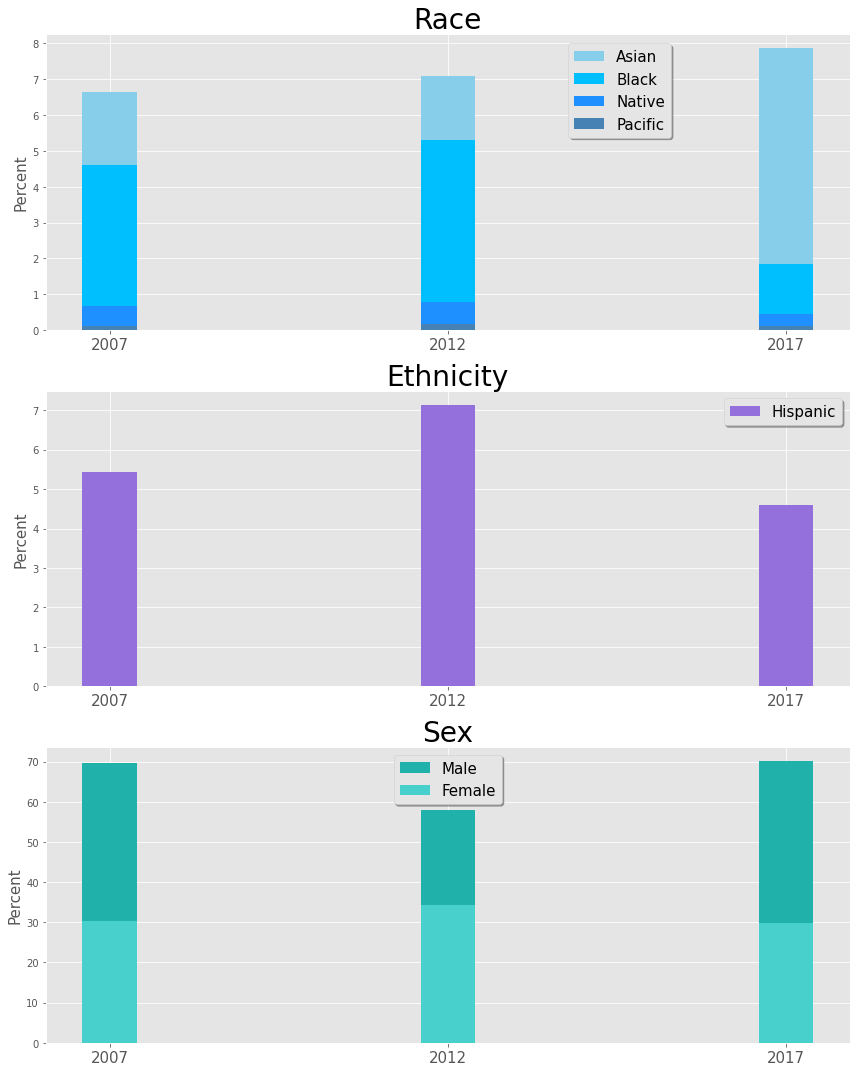

In [123]:
fig, ax = plt.subplots(3,1,figsize=(12,15))

ax[0].set_xticks(ylist)
ax[0].set_xticklabels(ylist, fontsize=15)
ax[0].set_title('Race', fontsize=28)
ax[0].set_ylabel('Percent',fontsize=15)
ax[0].bar(ylist, asian_lst, color="skyblue", linewidth=4.00, label='Asian')
ax[0].bar(ylist, black_lst, color="deepskyblue", linewidth=4.00, label='Black')
ax[0].bar(ylist, native_lst, color="dodgerblue", linewidth=4.00, label='Native')
ax[0].bar(ylist, pacific_lst, color="steelblue", linewidth=4.00, label='Pacific')
ax[0].legend(loc=(.65,.65), shadow=True, fontsize=15)
ax[1].set_xticks(ylist)
ax[1].set_xticklabels(ylist, fontsize=15)
ax[1].set_ylabel('Percent', fontsize=15)
ax[1].set_title('Ethnicity', fontsize=28)
ax[1].bar(ylist, hispanic_lst, color="mediumpurple", linewidth=4.00, label='Hispanic')
ax[1].legend(loc=0, shadow=True, fontsize=15)
ax[2].set_xticks(ylist)
ax[2].set_xticklabels(ylist, fontsize=15)
ax[2].set_ylabel('Percent', fontsize=15)
ax[2].set_title('Sex', fontsize=28)
ax[2].bar(ylist, male_lst, color="lightseagreen", linewidth=4.00, label='Male')
ax[2].bar(ylist, female_lst, color="mediumturquoise", linewidth=4.00, label="Female")
ax[2].legend(loc=0, shadow=True, fontsize=15)
fig.tight_layout()

plt.savefig('stacked.png')